<a href="https://colab.research.google.com/github/eunhaday/AIffel_Datathon/blob/master/AIFFELTHON_PRJ/pymunk_test_neh_0108_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pip를 사용하여 Ultralytics 설치
!pip install pymunk
!pip install ultralytics
!pip show pymunk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 15.7 MB/s eta 0:00:00
Name: pymunk
Version: 6.10.0
Summary: Pymunk is a easy-to-use pythonic 2D physics library
Home-page: https://www.pymunk.org
Author: 
Author-email: Victor Blomqvist <vb@viblo.se>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: cffi
Required-by: 


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 736x1280 1 frame, 2 red balls, 1 table, 1 white ball, 1 yellow ball, 1462.7ms
Speed: 44.0ms preprocess, 1462.7ms inference, 35.9ms postprocess per image at shape (1, 3, 736, 1280)
YOLOv8 Model Classes:
Class ID: 0, Class Name: blue ball
Class ID: 1, Class Name: frame
Class ID: 2, Class Name: red ball
Class ID: 3, Class Name: table
Class ID: 4, Class Name: white ball
Class ID: 5, Class Name: yellow ball


Class_ID: 3, Class_Name: table, Confidence: 0.98, Box: [379.36871337890625, 256.9002685546875, 1541.3411865234375, 830.6531982421875]
Class_ID: 1, Class_Name: frame, Confidence: 0.95, Box: [333.01373291015625, 181.06988525390625, 1610.12158203125, 887.58056640625]
Class_ID: 4,

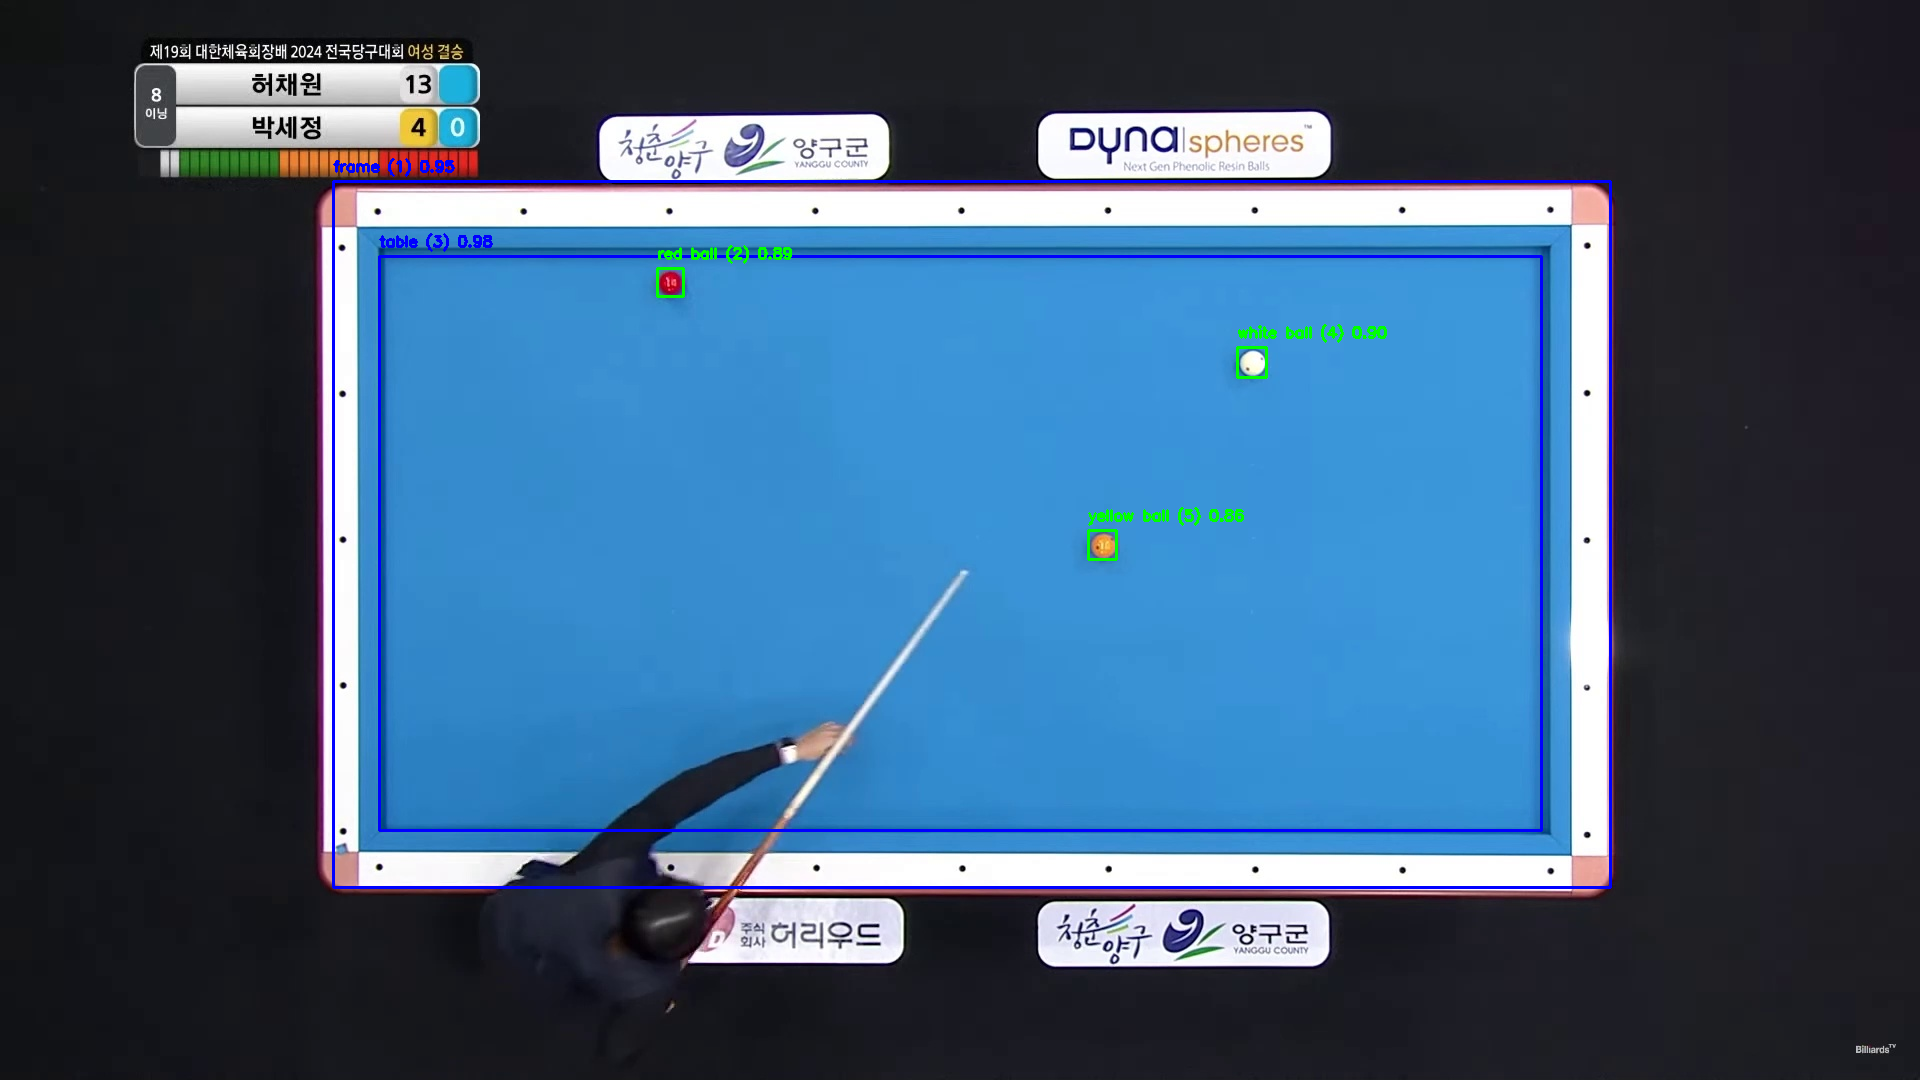

bounds: (1920, 1080)


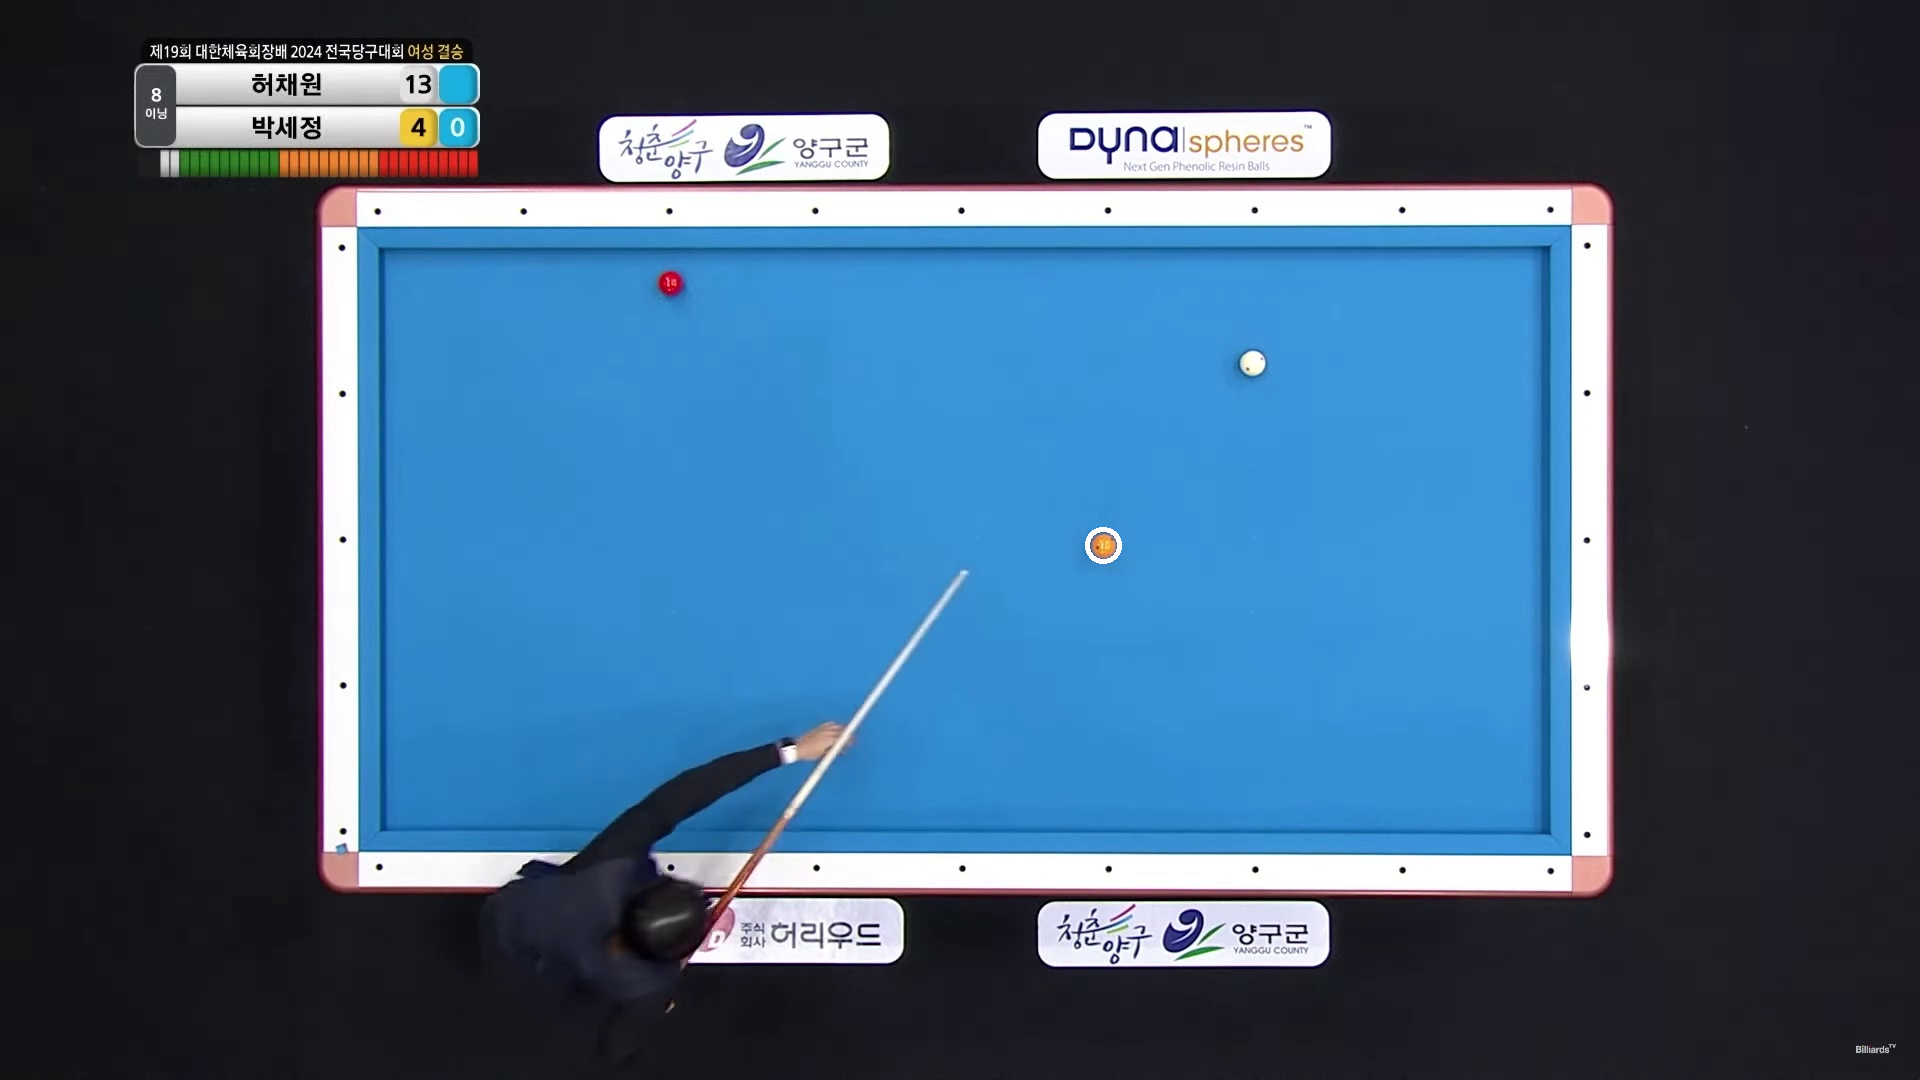

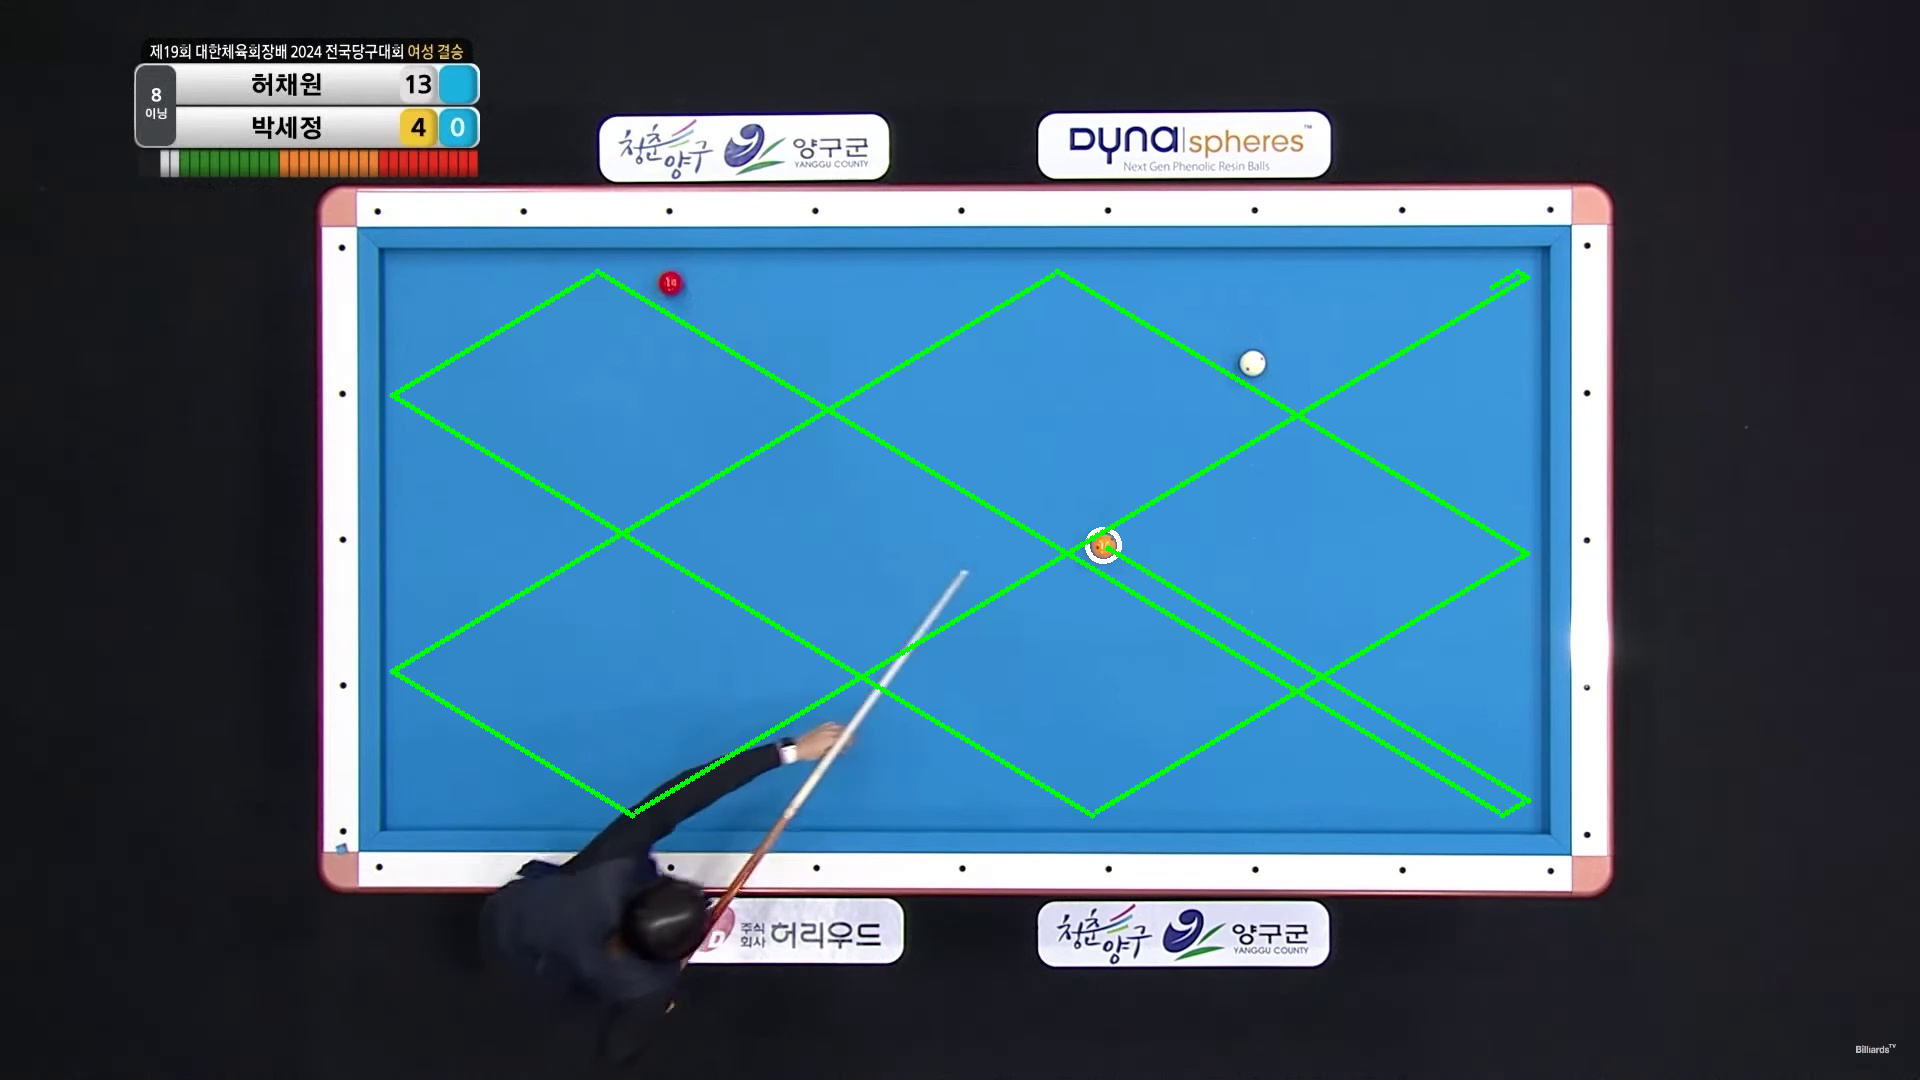

In [3]:
#-------------------------------------------------------------------------------------------
# 2025.01.03, neh
# pymunk 이용하여 이미지를 읽고 그 이미지의 table크기내에서 공의 경로를 그리게 처리하기
#
# 현재로서는 여기부분이 최종임
# 2025.01.08 기능추가 : 공을 수구와 목적구로 나누고 각공을 맞추게 추가
#-------------------------------------------------------------------------------------------

import cv2
from ultralytics import YOLO  # YOLOv8를 사용하여 객체 검출
import pandas as pd
import numpy as np
import pymunk
from pymunk import Vec2d
from google.colab.patches import cv2_imshow  # Colab 환경에서 이미지 표시용

# 사전학습된 모델 가져오기
model = YOLO("/content/drive/MyDrive/qpit_prj/data/best_Mansoon.pt")

# 이미지 읽기(추후 사용자가 보내준 이미지를 읽는 방법으로 수정필요)
image_path = '/content/drive/MyDrive/Billiard/Input_mp4/frames/single_frame.jpg'
#'/content/drive/MyDrive/Billiard/1-1.png'
image = cv2.imread(image_path)

# YOLO 모델로 이미지 분석
results = model(image)

# 클래스 이름 확인
class_names = model.names  # 모델에 저장된 클래스 이름들

# 이미지 복사본 생성 (결과를 그리기 위해)
output_image = image.copy()

# table 객체 정보 (table을 ball 안에서만 인정하기 위해 사용)
table_box = None
cue_ball_pos = None
red_ball_pos = None
white_ball_pos = None
yellow_ball_pos = None

# 모델의 클래스 정보 출력
print("YOLOv8 Model Classes:")
for cls_id, class_name in model.names.items():
    print(f"Class ID: {cls_id}, Class Name: {class_name}")
print('\n')

#----------------------------------
# 결과에서 객체 정보 추출
#----------------------------------
for detection in results[0].boxes:
    # 검출된 객체의 좌표, 클래스 ID 및 신뢰도
    box = detection.xyxy[0].tolist()  # [x1, y1, x2, y2]
    class_id = int(detection.cls[0])  # 클래스 ID
    confidence = detection.conf[0]  # 신뢰도

    # 클래스 이름 가져오기
    class_name = class_names[class_id]

    # 클래스 이름 출력
    print(f"Class_ID: {class_id}, Class_Name: {class_name}, Confidence: {confidence:.2f}, Box: {box}")

    # 'table' 객체를 찾으면 box 저장
    if class_name == 'table':
        table_box = box  # table의 좌표를 저장
        cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)
        text = f"{class_name} ({class_id}) {confidence:.2f}"
        cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)



#----------------------------------------------------------------------------
# table이 감지된 경우, table 내의 특정 ball만 인정하고 나머지는 그대로 처리
# table내 감지된 공 및 테이블, frame정보 -> csv파일로 저장하기
#----------------------------------------------------------------------------
if table_box is not None:
    # table의 경계 정보
    table_x1, table_y1, table_x2, table_y2 = table_box

    # CSV 파일에 쓸 내용 준비
    detected_objects = []

    # white ball, red ball, yellow ball만 table 내에 있을 경우 박스를 그려줌
    for detection in results[0].boxes:
        box = detection.xyxy[0].tolist()  # [x1, y1, x2, y2]
        class_id = int(detection.cls[0])  # 클래스 ID
        confidence = detection.conf[0]  # 신뢰도

        # 클래스 이름 가져오기
        class_name = class_names[class_id]

        # ball 객체인 경우
        if class_name in ['white ball', 'red ball', 'yellow ball']:
            ball_x1, ball_y1, ball_x2, ball_y2 = box

            # ball이 table 안에 있는지 확인
            if (ball_x1 >= table_x1 and ball_y1 >= table_y1 and ball_x2 <= table_x2 and ball_y2 <= table_y2):
                # table 안에 있을 경우, 박스를 그림
                cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
                text = f"{class_name} ({class_id}) {confidence:.2f}"
                cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                #사용자가 선택한 공을 설정하고, 그 공을 기준으로 큐볼, 목적공을 세팅한다.
                if class_name == "yellow ball":
                    yellow_ball_pos = (ball_x1, ball_y1)
                elif class_name == "red ball":
                    red_ball_pos = (ball_x1, ball_y1)
                elif class_name == "white ball":
                    white_ball_pos = (ball_x1, ball_y1)

                # CSV에 필요한 데이터 저장
                detected_objects.append({
                    'class_id': class_id,       # Class ID (e.g., 0: cue ball, 1: target ball)
                    'class_name': class_name,       # Class ID (e.g., 0: cue ball, 1: target ball)
                    'confidence': confidence,  # Confidence score
                    'box': box   # Bounding box center coordinates(x,y), box dimensions(w,h)
                })
        else:
            # 'ball'이 아닌 객체는 그냥 박스를 그려줌
            cv2.rectangle(output_image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)
            text = f"{class_name} ({class_id}) {confidence:.2f}"
            cv2.putText(output_image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # CSV에 필요한 데이터 저장
            detected_objects.append({
                'class_id': class_id,       # Class ID (e.g., 0: cue ball, 1: target ball)
                'class_name': class_name,       # Class ID (e.g., 0: cue ball, 1: target ball)
                'confidence': confidence,  # Confidence score
                'box': box   # Bounding box center coordinates(x,y), box dimensions(w,h)
            })

    # Save results to a CSV file
    pd.DataFrame(detected_objects).to_csv('/content/drive/MyDrive/qpit_prj/data/detected_objects.csv', index=False)

# 결과 이미지 표시
cv2_imshow(output_image)

#----------------------------------------------------------------------------
# table이 감지된 경우, table 내의 특정 ball만 인정하고 나머지는 그대로 처리
# table내 감지된 공 및 테이블, frame정보 -> csv파일로 저장하기
#----------------------------------------------------------------------------
# Pymunk 물리 시뮬레이션 공간 초기화 함수
def setup_physics_0103_org(space, table_box):
    """
    Pymunk 물리 공간에 당구대 벽과 공을 설정합니다.
    """
    # 중력을 (0, 0)으로 설정하여 당구 공의 움직임만 시뮬레이션
    space.gravity = (0, 0)

    # 고정된 벽을 추가 (당구대 경계)
    #width, height = bounds
    #print(f"전체화면크기 : {bounds}")
    t_x, t_y, t_w, t_h = table_box  #경계 상자 좌표 중심(x,y), box 크기(w,h), 당구대크기로 제한
    print(f"table 크기 : {table_box}")

    static_lines = [
        pymunk.Segment(space.static_body, (t_x, t_y), (t_w, 0), 1),     # 상단 벽
        pymunk.Segment(space.static_body, (t_x, t_y), (0, t_h), 1),    # 좌측 벽
        pymunk.Segment(space.static_body, (t_x+t_w, t_y), (t_w, t_h), 1),  # 우측 벽
        pymunk.Segment(space.static_body, (t_x, t_y+t_h), (t_w, t_h), 1)  # 하단 벽
    ]

    for line in static_lines:
        line.elasticity = 1.0  # 완전 탄성 충돌로 설정
        space.add(line)  # 물리 공간에 벽 추가
        options = pymunk.SpaceDebugDrawOptions()
        space.debug_draw(options)

def setup_physics(space, table_box):
    space.gravity = (0, 0)
    t_x1, t_y1, t_x2, t_y2 = table_box  #경계 상자 좌표 중심(x,y), box 크기(w,h), 당구대크기로 제한
    static_lines = [
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x2, t_y1), 1),  # 상단 벽
        pymunk.Segment(space.static_body, (t_x1, t_y1), (t_x1, t_y2), 1),  # 좌측 벽
        pymunk.Segment(space.static_body, (t_x2, t_y1), (t_x2, t_y2), 1),  # 우측 벽
        pymunk.Segment(space.static_body, (t_x1, t_y2), (t_x2, t_y2), 1),  # 하단 벽
    ]
    for line in static_lines:
        line.elasticity = 1.0
        space.add(line)


# 공을 OpenCV로 탐지하는 함수
def detect_org_cuball(image):
    """
    OpenCV를 사용하여 흰 공을 탐지합니다.
    """
    # 이미지를 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #cv2_imshow(gray)  # 변환된 이미지를 Colab에 출력

    # 블러링을 적용하여 노이즈 감소
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    #v2_imshow(blurred)  # 블러된 이미지를 Colab에 출력

    # 허프 서클 변환으로 원 탐지
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=30
    )
    cv2_imshow(circles)  # 탐지된 원 정보를 Colab에 출력

    # 원이 탐지된 경우
    if circles is not None:
        circles = np.uint16(np.around(circles))  # 정수로 반올림
        for circle in circles[0, :]:
            x, y, r = circle  # 원의 중심 좌표(x, y)와 반지름(r)
            # 탐지된 공을 표시
            cv2.circle(image, (x, y), r, (255, 255, 255), 3)  # 공의 경계를 흰색 원으로 그림
            cv2_imshow(image)  # 업데이트된 이미지를 Colab에 출력

            return (x, y), r  # 탐지된 공의 위치와 반지름 반환
    return None, None  # 탐지 실패 시 None 반환


# 큐볼공을 OpenCV로 탐지하는 함수
def detect_cuball(image, cuball_box):
    """
    OpenCV를 사용하여 큐볼공을 탐지합니다.
    """
    detected_ball_coords = [int(float(value)) for value in cuball_box] #사각형크기는 정수형으로 변환

    print(f"table_box: {cuball_box}")
    print(f"detected_ball_coords: {detected_ball_coords}")

    # 이미지를 그레이스케일로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)  # 변환된 이미지를 Colab에 출력

    # 관심 영역(잘라준-Croppe 관심 영역)
    x, y, w, h = detected_ball_coords
    print(f"x, y, w, h: {x, y, w, h}")
    roi = gray[y:y+h, x:x+w]

    # 허프 서클 변환으로 원 탐지
    circles = cv2.HoughCircles(
        roi,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=30,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=30
    )
    cv2_imshow(circles)  # 탐지된 원 정보를 Colab에 출력

    # 원이 탐지된 경우
    if circles is not None:
        circles = np.uint16(np.around(circles))  # 정수로 반올림
        for circle in circles[0, :]:

            # 원 중심과 반지름 (ROI 내부 좌표 기준)
            #x, y, r = circle  # 원의 중심 좌표(x, y)와 반지름(r)

            center = (circle[0], circle[1])  # x, y 중심
            radius = circle[2]  # 반지름

            # 실제 이미지 좌표로 변환
            center_in_image = (center[0] + x, center[1] + y)

            # 원 그리기
            cv2.circle(image, center_in_image, radius, (0, 255, 0), 2)
            cv2.circle(image, center_in_image, 2, (0, 0, 255), 3)  # 중심점

            # 탐지된 공을 표시
            #cv2.circle(image, (x, y), r, (255, 255, 255), 3)  # 공의 경계를 흰색 원으로 그림
            cv2_imshow(image)  # 업데이트된 이미지를 Colab에 출력

            #return (x, y), r  # 탐지된 공의 위치와 반지름 반환
            return center_in_image, radius  # 탐지된 공의 위치와 반지름 반환
    return None, None  # 탐지 실패 시 None 반환



# 경로를 시뮬레이션하는 함수
#def simulate_bounce_path(space, start_pos, velocity, bounds, max_bounces):
def simulate_bounce_path(space, start_pos, radius_new, velocity, table_box, max_bounces):
    """
    지정된 초기 조건으로 공의 이동 경로를 시뮬레이션합니다.
    """
    # 공의 물리적 속성을 정의
    body = pymunk.Body(mass=1, moment=10)  # 질량과 관성을 설정
    body.position = start_pos  # 시작 위치
    body.velocity = velocity  # 초기 속도 설정
    radius = radius_new  #10  # 공의 반지름(직접 확인한 공의 반지름)
    ball = pymunk.Circle(body, radius)
    ball.elasticity = 1.0  # 완전 탄성 충돌
    space.add(body, ball)  # 물리 공간에 공 추가
    t_x1, t_y1, t_w1, t_h1 = table_box

    # 시뮬레이션 및 경로 기록
    trajectory_points = []  # 공의 경로를 저장할 리스트
    bounces = 0  # 벽에 부딪힌 횟수 초기화
    for _ in range(1000):  # 500 스텝 동안 시뮬레이션 실행
        space.step(0.01)  # 시뮬레이션 시간 간격
        trajectory_points.append((int(body.position.x), int(body.position.y)))  # 현재 위치 추가

        # 벽과 충돌 확인 (경계 근처인지 확인)
        #if (body.position.x <= 0 or body.position.x >= bounds[0] or
        #    body.position.y <= 0 or body.position.y >= bounds[1]):
        # 벽과 충돌 확인 (경계 근처인지 확인)
        if (body.position.x <= 0 or body.position.x >= t_w1 or
            body.position.y <= 0 or body.position.y >= t_h1):
            bounces += 1

        # 최대 충돌 횟수에 도달하면 종료
        if bounces >= max_bounces:
            break

    return trajectory_points  # 경로 반환


# 메인 시뮬레이션 실행
bounds = (image.shape[1], image.shape[0])  # 이미지의 가로(width)와 세로(height) 크기
print(f'bounds: {bounds}')

space = pymunk.Space()  # Pymunk 공간 초기화

#사용자에게 받은 큐볼 색상을 yellow ball 로 일단 가정하여 처리

#etup_physics(space, bounds, table_box)  # 물리적 환경 설정
setup_physics(space, table_box)  # 물리적 환경 설정

# 흰 공 탐지 및 경로 시뮬레이션table_box
start_pos, radius_new = detect_org_cuball(image)
#start_pos, radius = detect_cuball(image, table_box)


if start_pos:  # 공이 탐지된 경우
    velocity = (500, 300)  # 초기 속도 벡터(x, y 방향 속도)
    max_bounces = 4  # 최대 충돌 횟수
    #trajectory = simulate_bounce_path(space, start_pos, velocity, bounds, max_bounces)
    trajectory = simulate_bounce_path(space, start_pos, radius_new, velocity, table_box, max_bounces)

    # 이미지에 경로 표시
    for point in trajectory:
        cv2.circle(image, point, 3, (0, 255, 0), -1)  # 경로를 초록색 점으로 표시


# 결과 출력
cv2_imshow(image)  # 결과 이미지를 Colab에 출력
cv2.waitKey(0)  # 키 입력 대기
cv2.destroyAllWindows()  # 모든 OpenCV 창 닫기
